In [1]:
import functions.hf_config as hf_config
from functions.adviser_tool import create_adviser_tool
from functions.loader import create_loader_tool
from functions.python_repl_tool import create_python_repl
from functions.utils import get_llm, get_prompt
from langchain.agents import AgentExecutor, create_tool_calling_agent
from getpass import getpass
from executor import load_agent_executor
from functions.db_creation import create_db_examples

In [2]:
import os

In [3]:
token = getpass()

 ········


In [4]:
#hf_config.set_hf_token(getpass())

In [4]:
executor = load_agent_executor(token)

/home/jovyan/ohw25_proj_datadashboard_llm/final_notebooks/functions/db_creation.py:45: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vector_store_hf.persist()




> Entering new AgentExecutor chain...

Invoking: `adviser_tool` with `{'query': 'plot a timeseries of chlorophyll for 1 month in the Indian Ocean, single point, January 2020 start'}`




/home/jovyan/ohw25_proj_datadashboard_llm/final_notebooks/functions/adviser_tool.py:45: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vector_store_hf = Chroma(


dataset: Indian Ocean grid  
variable: CHL_cmes-level3  
lat,lon boundaries: global  
time range: 2020-01-01 to 2020-01-31  
suggestions: Indian Ocean  

You can use this code to analyse the data:

#dataset example
chl = dataset['CHL_cmes-gapfree'].sel(time='2020-01-01')
# Create figure and axis with a PlateCarree projection
fig, ax = plt.subplots(figsize=(10, 6),
                       subplot_kw={'projection': ccrs.PlateCarree()})

# Plot with log scale normalization
im = chl.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap=cmocean.cm.algae,        # cmocean colormap
    norm=LogNorm(vmin=chl.min().values, vmax=chl.max().values),
    add_colorbar=False
)

# Add coastlines and features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Add colorbar with log ticks
cbar = plt.colorbar(im, ax=ax, orientation='vertical', shrink=0.7, pad=0.05)
cbar.set_label('Chlorophyll Concentration (mg/m³)')

# Add title
ax.

Python REPL can execute arbitrary code. Use with caution.


Execution Result:
KeyError("'latitude' is not a valid dimension or coordinate for Dataset with dimensions FrozenMappingWarningOnValuesAccess({'lat': 177, 'lon': 241, 'time': 31})")

Executed Code:
import xarray as xr, matplotlib.pyplot as plt, numpy as np
import pandas as pd
import cmocean

# Open dataset from GCS
store = 'gcs://nmfs_odp_nwfsc/CB/mind_the_chl_gap/IO.zarr'
# Use fsspec to open
import fsspec
fs = fsspec.filesystem('gcs')
# Open via xarray
ds = xr.open_zarr(store, consolidated=False, storage_options={'token': 'anon'})
# Select variable
chl = ds['CHL_cmes-level3']
# Subset time for Jan 2020
chl_jan = chl.sel(time=slice('2020-01-01', '2020-01-31'))
# Choose point near (0 lat, 80 lon)
point = chl_jan.sel(latitude=0, longitude=80, method='nearest')
# Convert to pandas series
ts = point.to_series()
# Plot
ts.plot(marker='o')
plt.title('Chlorophyll (CHL_cmes-level3) Time Series at lat=%.2f, lon=%.2f (Jan 2020)'
          % (point.latitude.values, point.longitude.values))
plt.yl

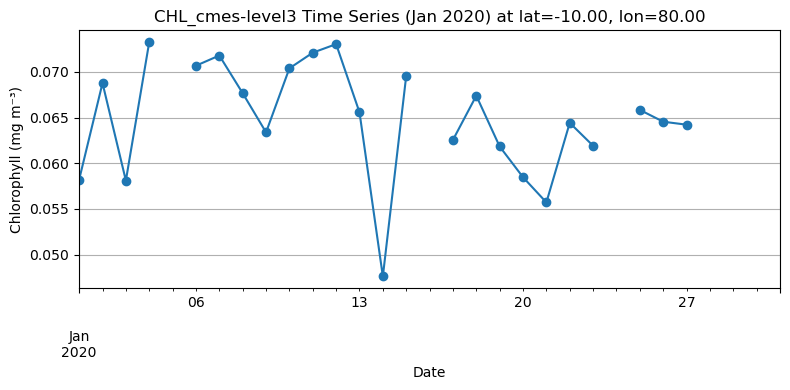

Execution Result:
Figure saved to: figures_temp/plot_20250822_184744_549_fig1.png


Saved Plots:
- figures_temp/plot_20250822_184744_549_fig1.png

Executed Code:
import xarray as xr, matplotlib.pyplot as plt
store='gcs://nmfs_odp_nwfsc/CB/mind_the_chl_gap/IO.zarr'
ds = xr.open_zarr(store, consolidated=False, storage_options={'token':'anon'})
chl = ds['CHL_cmes-level3']
# Subset time for Jan 2020
chl_jan = chl.sel(time=slice('2020-01-01','2020-01-31'))
# Choose point near lat=-10, lon=80 (nearest)
point = chl_jan.sel(lat=-10, lon=80, method='nearest')
# Convert to pandas Series
ts = point.to_series()
# Plot
plt.figure(figsize=(8,4))
ts.plot(marker='o')
plt.title(f'CHL_cmes-level3 Time Series (Jan 2020) at lat={float(point.lat.values):.2f}, lon={float(point.lon.values):.2f}')
plt.ylabel('Chlorophyll (mg m⁻³)')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()
Here is the time‑series of **chlorophyll (CHL_cmes‑level3)** for a single location in the Indian Ocean during the fi

In [5]:
r = executor.invoke({"input": "can you please plot a timeseries of chlorophyll for 1 month in the indian ocean. pick a single point. do 1 month at the beginning of january 2020."})

In [18]:
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True, handle_parsing_errors=True)

In [27]:
def load_agent_executor(token: str):
    chroma = create_db_examples()
    advisor_tool = create_advisor_tool()
    loader_tool = create_loader_tool()
    repl_tool = create_repl_tool()

    tools = [
        advisor_tool,
        loader_tool,
        repl_tool
    ]

    llm = get_llm()

    agent = create_tool_calling_agent(
        llm=llm,
        tools=tools,
        prompt=get_prompt(),
    )
    
    return AgentExecutor(agent=agent, tools=tools, verbose=True, handle_parsing_errors=True)



> Entering new AgentExecutor chain...

Invoking: `adviser_tool` with `{'query': 'average chlorophyll for 1 hour at the beginning of January 2020 in the Indian Ocean'}`


dataset: Indian Ocean grid  
variable: CHL_cmes-level3  
lat,lon boundaries: global  
time range: full available  
suggestions: none

You can use this code to analyse the data:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

FILE_IN = "text.nc"

ds = xr.open_dataset(FILE_IN)
time = pd.to_datetime(ds["time"].values)
y = pd.Series(ds["analysed_sst"].values, index=time).astype(float)
y = y.interpolate(limit_direction="both")

run7  = y.rolling(window=7,  center=True, min_periods=1).mean()
run30 = y.rolling(window=30, center=True, min_periods=1).mean()


# 1) Original & running means
plt.figure(figsize=(12,4.5))
plt.plot(y.index, y.values, label="Original")
plt.plot(run7.index, run7.values, label="7-day running mean")
plt.plot(run30.index, run30.values, label="30-day running m

<Figure size 1000x600 with 0 Axes>


Invoking: `python_repl` with `import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

file_path = 'temp/CHL_cmes-level3_20250822_172324.nc'
ds = xr.open_dataset(file_path)

# Variable
chl = ds['CHL_cmes-level3']

# Select the time (first hour of Jan 2020)
chl_time = chl.sel(time='2020-01-01T00:00:00')

# Subset to Indian Ocean region (lon 30-120E, lat -40 to 30)
chl_region = chl_time.sel(lon=slice(30, 120), lat=slice(30, -40))  # note lat decreasing order

# Mask non-positive values for log scale
chl_region = chl_region.where(chl_region > 0)

# Determine vmin/vmax for log norm (avoid zero)
vmin = float(chl_region.min())
vmax = float(chl_region.max())

norm = colors.LogNorm(vmin=vmin, vmax=vmax)

plt.figure(figsize=(10,6))
chl_region.plot(cmap='Greens', norm=norm, cbar_kwargs={'label':'Chlorophyll (mg m⁻³)'})
plt.title('Average Chlorophyll Concentration (1‑hour, 2020‑01‑01 00:00 UTC)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt

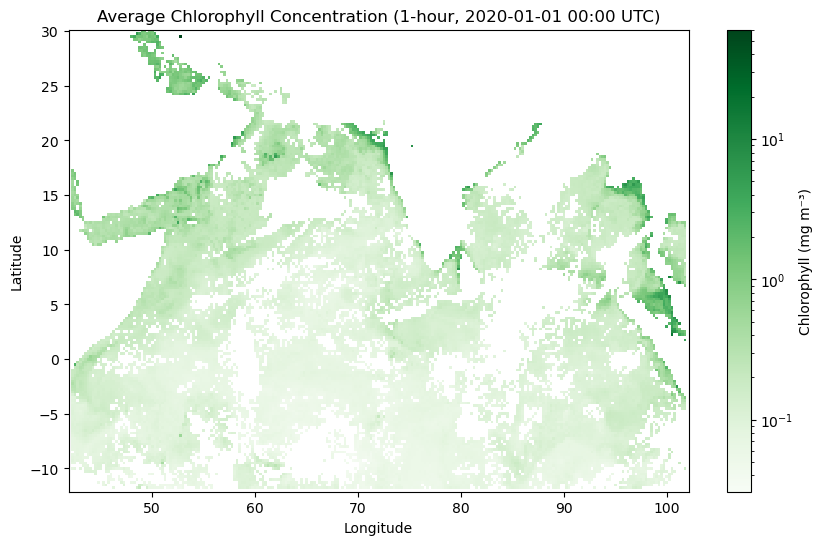


Invoking: `python_repl` with `import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

# Open the downloaded dataset
file_path = 'temp/CHL_cmes-level3_20250822_172324.nc'
ds = xr.open_dataset(file_path)

# Variable of interest
chl = ds['CHL_cmes-level3']

# Select the specific time (2020-01-01 00:00 UTC)
chl_time = chl.sel(time='2020-01-01T00:00:00')

# Subset to Indian Ocean region (lon 30E‑120E, lat -40 to 30)
chl_region = chl_time.sel(lon=slice(30, 120))
# Latitude may be descending; keep values between -40 and 30 regardless of order
chl_region = chl_region.where((chl_region.lat >= -40) & (chl_region.lat <= 30), drop=True)

# Remove non‑positive values because we will use a log colour scale
chl_region = chl_region.where(chl_region > 0)

# Compute vmin/vmax for LogNorm (avoid zero)
vmin = float(chl_region.min())
vmax = float(chl_region.max())

norm = colors.LogNorm(vmin=vmin, vmax=vmax)

plt.figure(figsize=(10,6))
chl_region.plot(cma

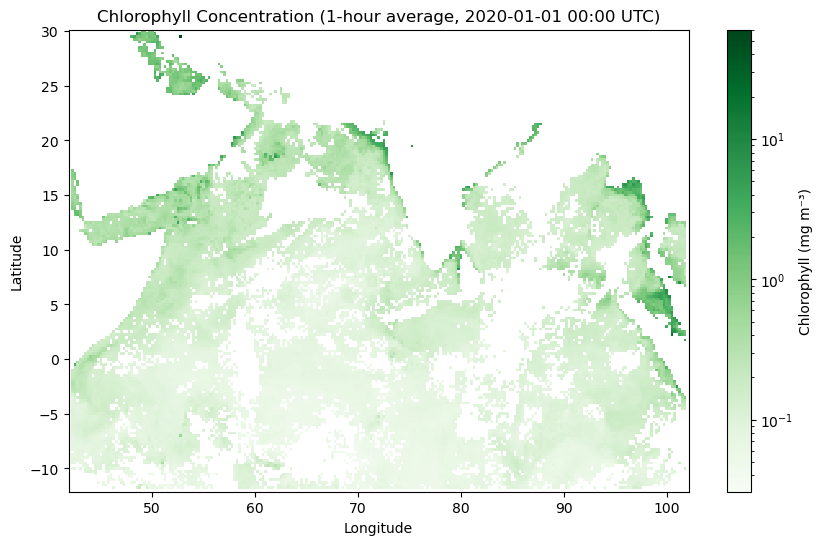

Here is the plot of the **average chlorophyll concentration** for the first hour of **January 1 2020** over the Indian Ocean (approximately 30° E – 120° E, –40° S – 30° N).  

The data are displayed with a **logarithmic colour scale** and the **Greens** colormap, which emphasizes the wide range of chlorophyll values in the ocean. The colour bar on the right shows the concentration in milligrams per cubic metre (mg m⁻³). Darker greens correspond to lower concentrations, while brighter greens indicate higher chlorophyll levels.

> Finished chain.


In [29]:
r = agent_executor.invoke({"input": "can you please plot avg chlorophyll for 1 hour in the indian ocean. do 1 hour at the beginning of january 2020. please plot using a log scale. use a green colormap"})
#r = agent_executor.invoke({"input": "what would you like to be named? can be anything. be creative. please give a simple answer!"})
